<a href="https://colab.research.google.com/github/forsc/Tryout/blob/main/gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tensorflow import keras
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

180224/168052 [================================] - 0s 1us/step


In [2]:
import pandas as pd
citations_data = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

In [ ]:
citations_data.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [ ]:
citations_data.describe()

,target,source
count,5429.000000,5.429000e+03
mean,115009.455148,5.604759e+05
std,188229.783205,4.710471e+05
min,35.000000,3.500000e+01
25%,6334.000000,7.855200e+04
50%,31353.000000,5.233940e+05
75%,119686.000000,1.113995e+06
max,954315.000000,1.155073e+06


In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers_data = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers_data.shape)

Papers shape: (2708, 1435)


In [ ]:
print("Papers shape:", papers_data.shape)
papers_data.head()

Papers shape: (2708, 1435)


,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,term_10,term_11,term_12,term_13,term_14,term_15,term_16,term_17,term_18,term_19,term_20,term_21,term_22,term_23,term_24,term_25,term_26,term_27,term_28,term_29,term_30,term_31,term_32,term_33,term_34,term_35,term_36,term_37,term_38,...,term_1394,term_1395,term_1396,term_1397,term_1398,term_1399,term_1400,term_1401,term_1402,term_1403,term_1404,term_1405,term_1406,term_1407,term_1408,term_1409,term_1410,term_1411,term_1412,term_1413,term_1414,term_1415,term_1416,term_1417,term_1418,term_1419,term_1420,term_1421,term_1422,term_1423,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [ ]:
class_values = sorted(papers_data["subject"].unique())
class_idc = {name: id for id, name in enumerate(class_values)}
paper_idc = {name: idx for idx, name in enumerate(sorted(papers_data["paper_id"].unique()))}

papers_data["paper_id"] = papers_data["paper_id"].apply(lambda name: paper_idc[name])
citations_data["source"] = citations_data["source"].apply(lambda name: paper_idc[name])
citations_data["target"] = citations_data["target"].apply(lambda name: paper_idc[name])
papers_data["subject"] = papers_data["subject"].apply(lambda value: class_idc[value])

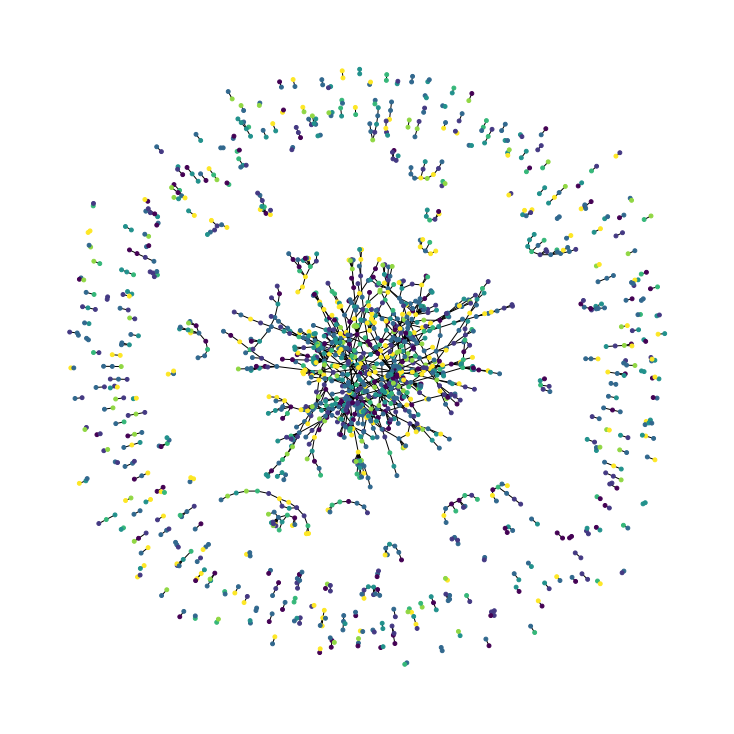

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
colors = papers_data["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations_data.sample(n=1500))
subjects = list(papers_data[papers_data["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


In [ ]:
import numpy as np
train, test = [], []

for _, group in papers_data.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group.index)) <= 0.5
    train.append(group[random_selection])
    test.append(group[~random_selection])

train = pd.concat(train).sample(frac=1)
test = pd.concat(test).sample(frac=1)

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)

Train data shape: (1330, 1435)
Test data shape: (1378, 1435)


In [ ]:
import tensorflow as tf
feature_names = set(papers.columns) - {"paper_id", "subject"}
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations_data[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers_data.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [ ]:
print("Edges_weights shape:", edge_weights.shape)

Edges_weights shape: (5429,)


In [ ]:
from tensorflow.keras import layers
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [ ]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [ ]:
num_features = len(feature_names)
num_classes = len(class_idc)
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.04398482 -0.01597942 -0.09554692 -0.04706811 -0.02255987  0.09242554
  -0.06403407]
 [ 0.10345042 -0.00051623 -0.15177356  0.03550602  0.04681654  0.11661859
   0.10481767]
 [-0.00911378 -0.06889356 -0.04124405 -0.07512642  0.01853462  0.04210536
  -0.00568597]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

In [ ]:
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [ ]:
x_train = train_data.paper_id.to_numpy()
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 6s 356ms/step - loss: 2.1695 - acc: 0.1927 - val_loss: 1.8986 - val_acc: 0.2598
Epoch 2/300
5/5 [==============================] - 1s 200ms/step - loss: 2.0133 - acc: 0.2526 - val_loss: 1.8919 - val_acc: 0.2598
Epoch 3/300
5/5 [==============================] - 1s 191ms/step - loss: 1.9197 - acc: 0.2977 - val_loss: 1.8941 - val_acc: 0.2598
Epoch 4/300
5/5 [==============================] - 1s 183ms/step - loss: 1.8668 - acc: 0.2830 - val_loss: 1.8935 - val_acc: 0.2598
Epoch 5/300
5/5 [==============================] - 1s 183ms/step - loss: 1.8382 - acc: 0.2977 - val_loss: 1.8856 - val_acc: 0.2598
Epoch 6/300
5/5 [==============================] - 1s 183ms/step - loss: 1.8188 - acc: 0.3116 - val_loss: 1.8766 - val_acc: 0.2598
Epoch 7/300
5/5 [==============================] - 1s 178ms/step - loss: 1.8285 - acc: 0.3012 - val_loss: 1.8701 - val_acc: 0.2598
Epoch 8/300
5/5 [==============================] - 1s 195ms/step - loss: 1.8282 - a

Text(0, 0.5, 'Loss')

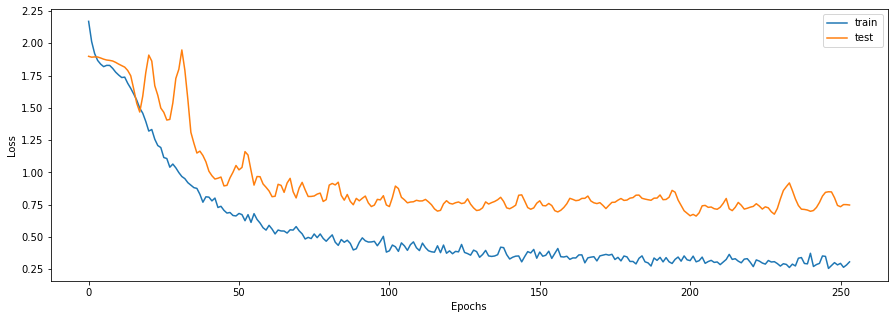

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(15, 5))

ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "test"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")



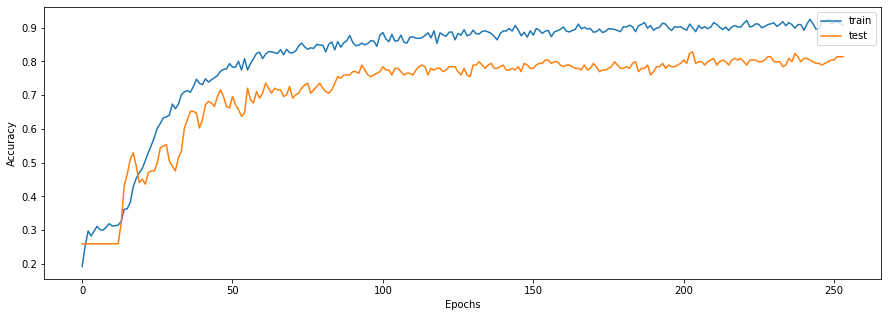

In [ ]:
fig, ax2 = plt.subplots(1, figsize=(15, 5))
ax2.plot(history.history["acc"])
ax2.plot(history.history["val_acc"])
ax2.legend(["train", "test"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()